In [67]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
pd.set_option('display.max_columns', None)

In [69]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [70]:
agg_strats = ['mean','00','15','30','45','min','max','std','median']
#agg_strats = ['mean']


m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [71]:
# get data
# X_train, y_train = m_wrap.get_train(aggregated=False,drop_val=True,drop_test=False)
# X_val, y_val = m_wrap.get_val(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)
# X_sub = m_wrap.get_sub(aggregated=False)
# X_test, y_test = m_wrap.get_test(aggregated=False)


X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=True,y_scaled=True)
#X_val_agg, y_val_agg = m_wrap.get_val(aggregated=True)
X_test_agg, y_test_agg = m_wrap.get_test(aggregated=True,y_scaled=False)
X_sub_agg = m_wrap.get_sub(aggregated=True)

In [72]:
val_idx = X_train_agg['date_forecast'].between('2020-05-01', '2020-07-01')-1
ps = PredefinedSplit(test_fold=val_idx)

In [73]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# exclude datetime columns
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])
#X_val_agg = X_val_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

print(f"categorical_features: {categorical_features}")
print(f"impute_features: {impute_features}")


columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

mod = CatBoostRegressor(
    max_depth=8,
    n_estimators=800,
    l2_leaf_reg=1,
)

open('status.csv', 'w').close()
# build the pipeline
mod_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', mod)
])

categorical_features: ['building_id']
impute_features: ['delta_forecast', 'mean_ceiling_height_agl:m', 'mean_cloud_base_agl:m', 'mean_snow_density:kgm3', 'mean_effective_cloud_cover_5h_mean', 'mean_GHI_lag_-1h', 'mean_GHI_lag_1h', 'mean_temp*GHI_lag_-1h', 'mean_temp*GHI_lag_1h', '00_ceiling_height_agl:m', '00_cloud_base_agl:m', '00_snow_density:kgm3', '00_effective_cloud_cover_5h_mean', '00_GHI_lag_-1h', '00_GHI_lag_1h', '00_temp*GHI_lag_-1h', '00_temp*GHI_lag_1h', '15_ceiling_height_agl:m', '15_cloud_base_agl:m', '15_snow_density:kgm3', '15_effective_cloud_cover_5h_mean', '15_GHI_lag_-1h', '15_GHI_lag_1h', '15_temp*GHI_lag_-1h', '15_temp*GHI_lag_1h', '30_ceiling_height_agl:m', '30_cloud_base_agl:m', '30_snow_density:kgm3', '30_effective_cloud_cover_5h_mean', '30_GHI_lag_-1h', '30_GHI_lag_1h', '30_temp*GHI_lag_-1h', '30_temp*GHI_lag_1h', '45_ceiling_height_agl:m', '45_cloud_base_agl:m', '45_snow_density:kgm3', '45_effective_cloud_cover_5h_mean', '45_GHI_lag_-1h', '45_GHI_lag_1h', '45_t

In [74]:
def std_per_sample(y, y_pred):
    return np.std((y - y_pred), axis=0)

std_scorer = make_scorer(std_per_sample, greater_is_better=False)

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'STD': std_scorer
}

In [75]:
# run grid search
gs = GridSearchCV(
    mod_pipe,
    param_grid={
        # 'estimator__iterations': [800,1000,1200],
        # 'estimator__depth': [4,6,8,10,12],
        # 'estimator__learning-rate': Real(30, 200),
        # 'estimator__l2_leaf_reg': [0,1,2,4,8,16],
        # 'estimator__loss_function':['RMSE','MAE'],
    },
    cv=ps,
    n_jobs=-1,
    scoring=scoring,
    verbose=2,
    refit='MAE'
)



# bs = BayesSearchCV(
#     mod_pipe,
#     search_spaces={
#         'estimator__iterations': Integer(100, 2000),
#         'estimator__depth': Integer(3, 14),
#         # 'estimator__learning-rate': Real(30, 200),
#         'estimator__l2_leaf_reg': Real(0, 30)
#     },
#     cv=ps,
#     n_jobs=-1,
#     scoring='neg_mean_absolute_error',
#     verbose=2,
#     n_iter=100,
#     n_points=6,
#     return_train_score=True
# )

gs.fit(X_train_agg, y_train_agg)


Fitting 1 folds for each of 2 candidates, totalling 2 fits


3119.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3119.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3119.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3119.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3119.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3119.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3119.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
3119.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed.

0:	learn: 0.2107212	total: 178ms	remaining: 2m 22s
1:	learn: 0.2057416	total: 354ms	remaining: 2m 21s
0:	learn: 0.1399091	total: 312ms	remaining: 4m 9s
2:	learn: 0.2009640	total: 472ms	remaining: 2m 5s
1:	learn: 0.1370904	total: 466ms	remaining: 3m 6s
3:	learn: 0.1963522	total: 596ms	remaining: 1m 58s
2:	learn: 0.1337187	total: 602ms	remaining: 2m 39s
4:	learn: 0.1919080	total: 719ms	remaining: 1m 54s
3:	learn: 0.1307125	total: 751ms	remaining: 2m 29s
5:	learn: 0.1875441	total: 844ms	remaining: 1m 51s
4:	learn: 0.1272841	total: 911ms	remaining: 2m 24s
6:	learn: 0.1833246	total: 978ms	remaining: 1m 50s
7:	learn: 0.1792662	total: 1.11s	remaining: 1m 49s
5:	learn: 0.1245086	total: 1.07s	remaining: 2m 22s
6:	learn: 0.1213282	total: 1.21s	remaining: 2m 16s
8:	learn: 0.1753967	total: 1.27s	remaining: 1m 51s
7:	learn: 0.1184257	total: 1.37s	remaining: 2m 15s
9:	learn: 0.1716167	total: 1.41s	remaining: 1m 51s
8:	learn: 0.1156582	total: 1.5s	remaining: 2m 11s
10:	learn: 0.1679260	total: 1.56s	r

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['delta_forecast',
                                                                          'mean_ceiling_height_agl:m',
                                                                          'mean_cloud_base_agl:m',
                                                                          'mean_snow_density:kgm3',
                                                                          'mean_effective_cloud_cover_...
                                                                        ('oneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['building_id'])])),
                                       ('statusSaver', StatusSaver()),
                                       ('estimator',
                                        <catboost.core.CatBoostRegressor object at 0x1797afb10>)]),
             n_jobs=-1,
             param_grid={'estimator__loss_function': ['RMSE', 'MAE']},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'STD': make_scorer(std_per_sample, greater_is_better=False)},
             verbose=2)

In [76]:
gs.best_params_

{'estimator__loss_function': 'MAE'}

In [77]:
model = gs.best_estimator_

In [78]:
# get val scores
# sns.lineplot(gs.cv_results_['mean_test_score'])

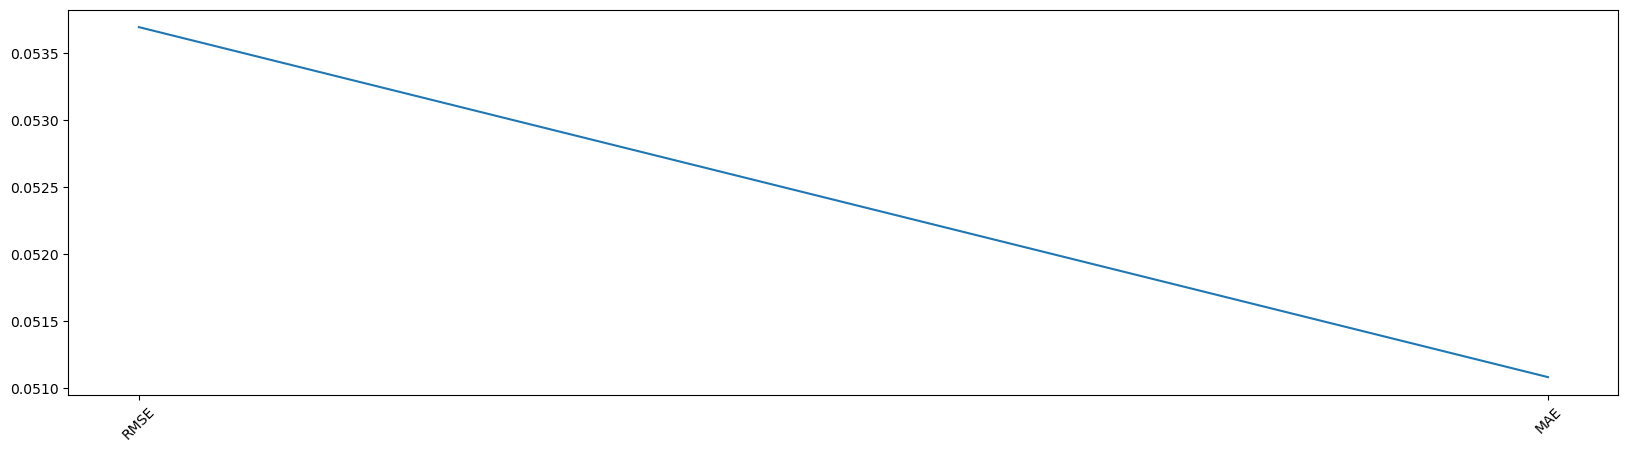

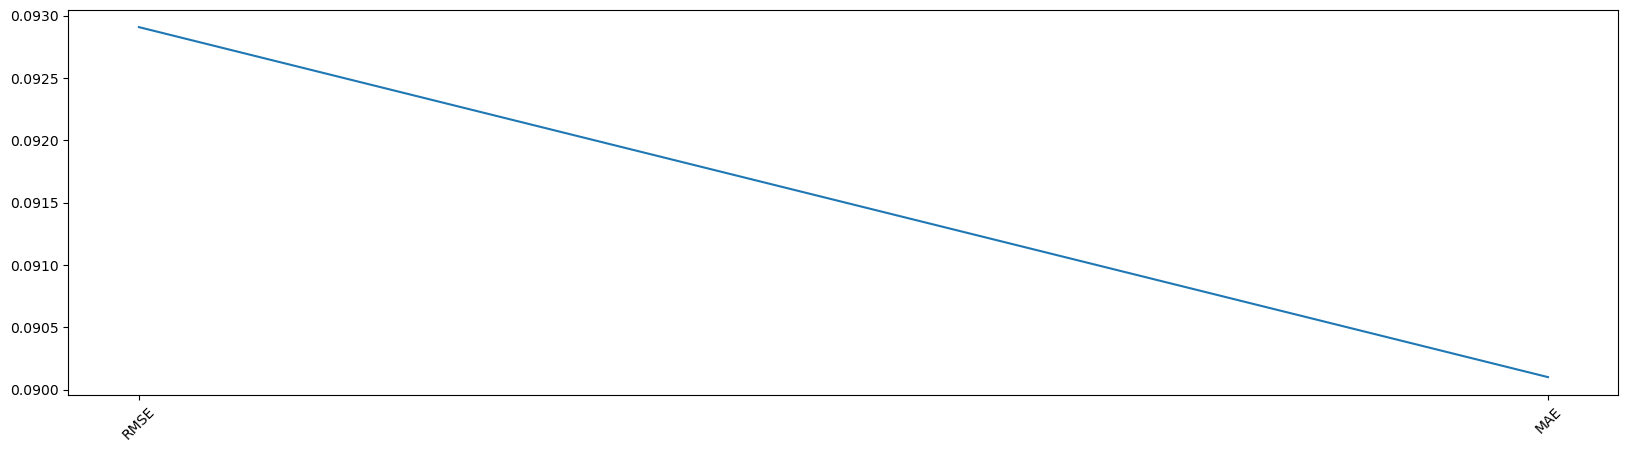

In [79]:
for key, values in gs.param_grid.items():
    pass

plt.figure(figsize=(20, 5))

sns.lineplot(y=gs.cv_results_['mean_test_MAE']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);

plt.figure(figsize=(20, 5))
sns.lineplot(y=gs.cv_results_['mean_test_STD']*-1, x=list(map(str, values)))
plt.xticks(rotation=45);

In [80]:
gs

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         SimpleImputer(strategy='constant'),
                                                                         ['delta_forecast',
                                                                          'mean_ceiling_height_agl:m',
                                                                          'mean_cloud_base_agl:m',
                                                                          'mean_snow_density:kgm3',
                                                                          'mean_effective_cloud_cover_...
                                                                        ('oneHotEncoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['building_id'])])),
                                       ('statusSaver', StatusSaver()),
                                       ('estimator',
                                        <catboost.core.CatBoostRegressor object at 0x1797afb10>)]),
             n_jobs=-1,
             param_grid={'estimator__loss_function': ['RMSE', 'MAE']},
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'STD': make_scorer(std_per_sample, greater_is_better=False)},
             verbose=2)

In [81]:
pred = pd.Series(model.predict(X_test_agg))

In [82]:
mae = m_wrap.get_mae(pred,X_test_agg, y_test_agg, is_aggregated=True)
print(f'MAE: {mae}')

MAE: 141.9577384546014


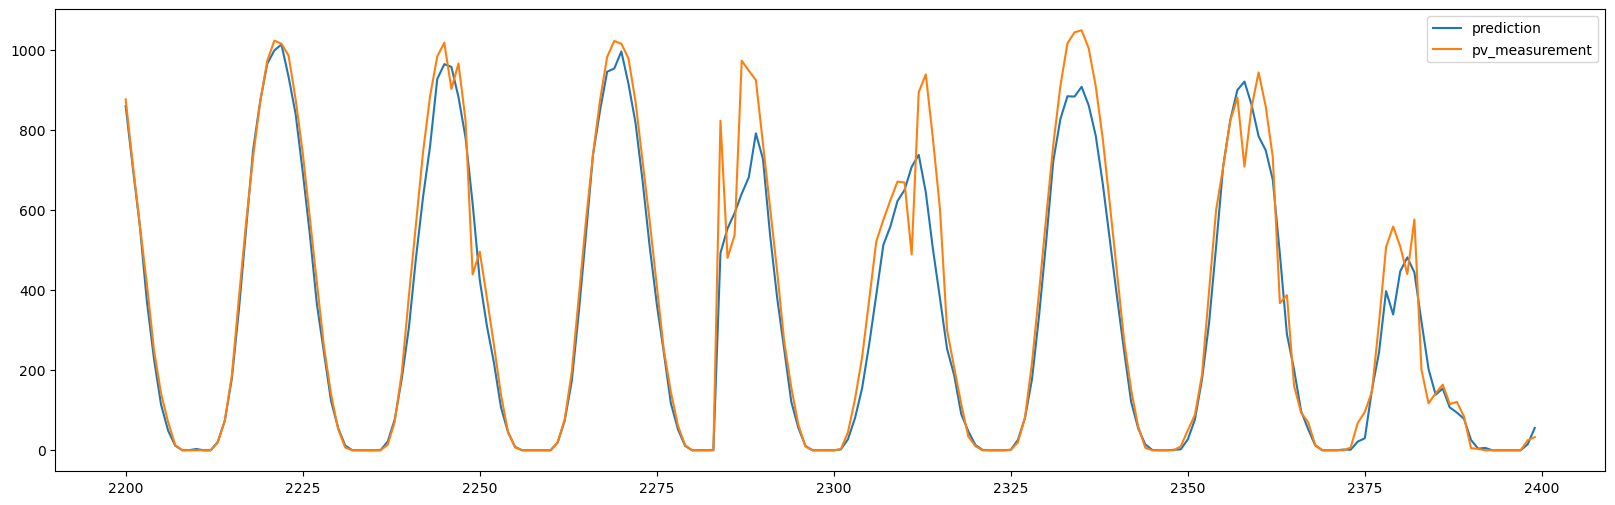

In [83]:
m_wrap.plot_Pred_vs_PV(pred,y_test_agg,X_test_agg,start_idx=2200,end_idx=2400)

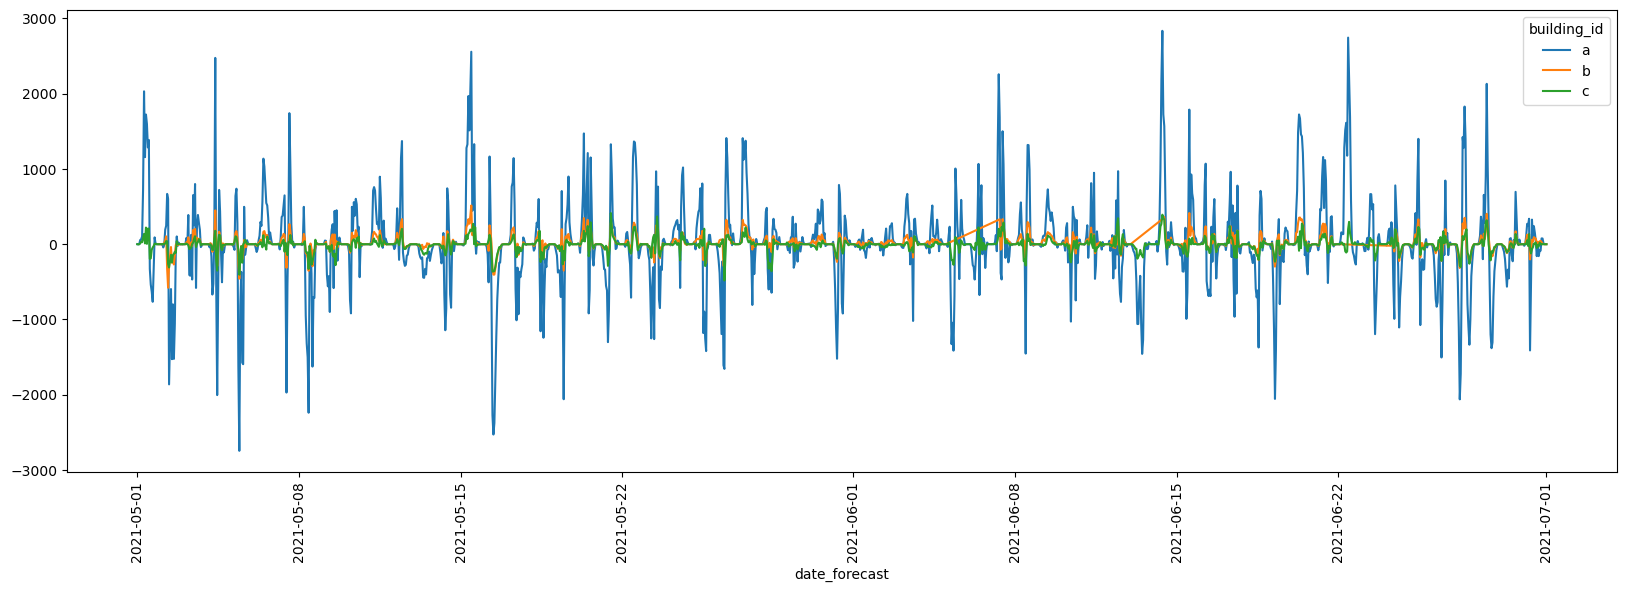

In [84]:
m_wrap.plot_Residuals(pred,y_test_agg,X_test_agg)

In [88]:
pred_sub = pd.Series(model.predict(X_sub_agg))
m_wrap.y_pred_to_csv(pred_sub, X_sub_agg, is_aggregated=True,name='catboost_mae_1.csv',sun_el_thr=1)

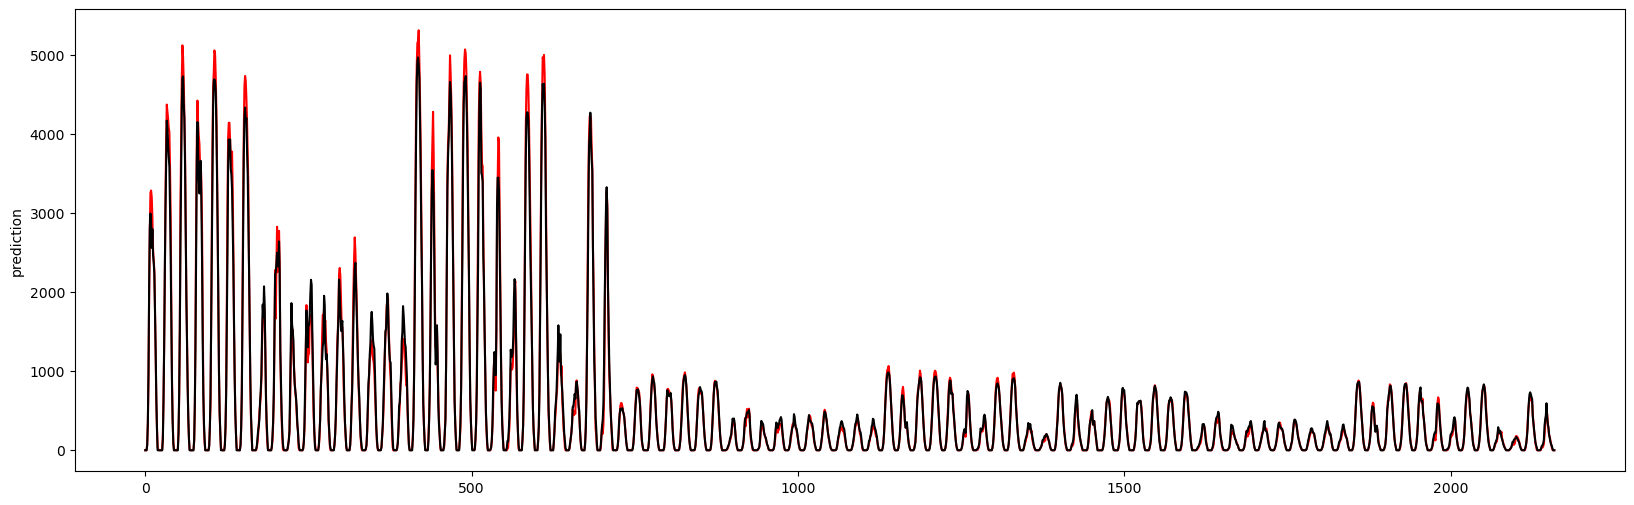

In [86]:
m_wrap.plot_yPredSub_vs_submission(pred_sub,X_sub_agg,sub_file='./submission_files/149_671661_ensemble.csv')